In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

from sklearn.metrics import mean_absolute_error, mean_squared_error
from numpy import sqrt

In [46]:
dataset = pd.read_csv("zomato.csv")

In [47]:
dataset.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-08-24,127.250000,127.949997,120.500000,125.000000,125.000000,56713556
1,2021-08-25,126.000000,128.500000,123.099998,124.250000,124.250000,51078811
2,2021-08-26,125.250000,127.150002,124.349998,125.849998,125.849998,20645403
3,2021-08-27,126.599998,129.500000,124.099998,124.699997,124.699997,22227595
4,2021-08-30,127.849998,135.449997,127.550003,133.550003,133.550003,45239080
5,2021-08-31,134.000000,135.199997,131.350006,134.550003,134.550003,24640924
6,2021-09-01,134.550003,135.100006,130.699997,132.600006,132.600006,16162269
7,2021-09-02,132.000000,138.500000,131.500000,137.600006,137.600006,27882466
8,2021-09-03,135.949997,151.399994,135.600006,149.750000,149.750000,113381518
9,2021-09-06,149.250000,149.350006,143.250000,144.050003,144.050003,34811620


In [48]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       250 non-null    object 
 1   Open       250 non-null    float64
 2   High       250 non-null    float64
 3   Low        250 non-null    float64
 4   Close      250 non-null    float64
 5   Adj Close  250 non-null    float64
 6   Volume     250 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 13.8+ KB


In [49]:
# Since the date column is of object data type.. let us convert it to datetime datatype.
dataset = pd.read_csv("zomato.csv",
                      parse_dates=["Date"],
                      index_col=["Date"])

In [50]:
dataset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-08-24,127.250000,127.949997,120.500000,125.000000,125.000000,56713556
2021-08-25,126.000000,128.500000,123.099998,124.250000,124.250000,51078811
2021-08-26,125.250000,127.150002,124.349998,125.849998,125.849998,20645403
2021-08-27,126.599998,129.500000,124.099998,124.699997,124.699997,22227595
2021-08-30,127.849998,135.449997,127.550003,133.550003,133.550003,45239080


## Objective of the project

In this project I want to predict the closing prices of Zomato Stocks for next 7 days.

Since I want to deal with the closing prices only, so let us drop other columns.


In [51]:
dataset.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [52]:
dataset = dataset.drop(columns=["Open", "High", "Low", "Adj Close", "Volume"])

In [53]:
dataset.head()

,Close
Date,
2021-08-24,125.000000
2021-08-25,124.250000
2021-08-26,125.849998
2021-08-27,124.699997
2021-08-30,133.550003


Text(0.5, 1.0, 'Zomato stocks closing price time series')

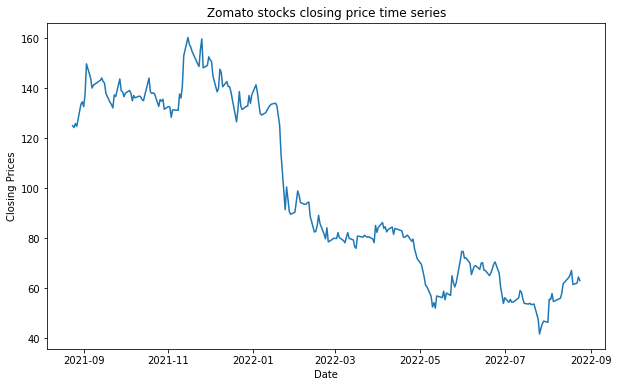

In [54]:
# Now let us plot these closing prices..
plt.figure(figsize=(10,6))
plt.plot(dataset.Close)
plt.xlabel("Date")
plt.ylabel("Closing Prices")
plt.title("Zomato stocks closing price time series")

In [55]:
# Let us convert this time series problem into a supervised machine learning problem by windowing the dataset.
# In the problem statement window size is not mentioned, hence I have presumed it to 30 days.
# Hence I am using past 30 days of closing prices to predict the next 7 days of closing prices.
 
HORIZON = 7
WINDOW_SIZE = 30

In [56]:
# Let us create a function to label the windowed dataset.
def get_labelled_windows(X, horizon):
  return X[:, :-horizon], X[:, -horizon:]

In [65]:
def make_windows(X, window_size=30, horizon=7):
  """This function will convert a 1D array into a 2D array of sequential windows of given window size
  """
  # Create a window of specific window size (here we will add the horizon too which will be splitted later for labelleing)
  window_step = np.expand_dims(np.arange(window_size + horizon), axis=0) 
  #print(window_step)

  # Create a 2D array of multiple window steps..
  window_indexes = window_step + np.expand_dims(np.arange(len(X) - (window_size+horizon-1)), axis=0).T
  #print(window_indexes)

  windowed_array = X[window_indexes]
  #print(windowed_array)

  # Now we will use get_labelled_windows function to split the windowed_array into windows and labels..
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

 

In [66]:
# Let us convert the timesteps and closing prices into numpy arrays.. then only we can do the numpy indexing.
timesteps = dataset.index.to_numpy()
closing_prices = dataset.Close.to_numpy()

In [67]:
full_windows, full_labels = make_windows(closing_prices)

In [71]:
# Check the length of full_windows and full_labels..
len(full_windows), len(full_labels), len(dataset)

(214, 214, 250)

In [70]:
# Let us check first 2 windows and labels..
# Our full_windows and full_labels are in a 2D numpy array..

for i in range(2):
  print(f"Window [{i+1}]    :\n{full_windows[i]}")
  print(f"Label [{i+1}]     :\n{full_labels[i]}")
  print()

Window [1]    :
[125.       124.25     125.849998 124.699997 133.550003 134.550003
 132.600006 137.600006 149.75     144.050003 140.050003 141.25
 141.600006 143.149994 144.100006 142.649994 142.050003 137.899994
 134.300003 133.449997 132.100006 137.300003 136.649994 143.699997
 139.       138.5      136.600006 138.       139.100006 137.949997]
Label [1]     :
[134.949997 137.100006 136.149994 136.850006 136.600006 135.449997
 135.      ]

Window [2]    :
[124.25     125.849998 124.699997 133.550003 134.550003 132.600006
 137.600006 149.75     144.050003 140.050003 141.25     141.600006
 143.149994 144.100006 142.649994 142.050003 137.899994 134.300003
 133.449997 132.100006 137.300003 136.649994 143.699997 139.
 138.5      136.600006 138.       139.100006 137.949997 134.949997]
Label [2]     :
[137.100006 136.149994 136.850006 136.600006 135.449997 135.
 144.050003]



In [72]:
# Now let us divide our supervised machine learning turned dataset into train and test sets.
# Since our dataset is very small hence we will use only 10% of the dataset into test dataset..

split_size= 21
train_windows = full_windows[:(1-split_size)]
train_labels = full_labels[:(1-split_size)]

test_windows = full_windows[(1-split_size):]
test_labels = full_labels[(1-split_size):]


In [73]:
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(194, 194, 20, 20)

### Model Building

Model_1 : Dense model
  - Activation - Relu
  - Units - 128
  - Optimzer - Adam
  - Loss - Mean Absolute Error
  - Epochs = 100


In [79]:
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(7)
    ])

# Compile the model
model_1.compile(loss=tf.keras.metrics.mean_absolute_error,
                optimizer=tf.keras.optimizers.Adam(),
                metrics="mae")

In [80]:
# Now fit the data into the model..
model_1.fit(x = train_windows,
            y = train_labels,
            epochs = 100,
            validation_data = (test_windows, test_labels))

Epoch 1/100
7/7 [==============================] - 1s 41ms/step - loss: 88.6310 - mae: 88.6310 - val_loss: 26.8401 - val_mae: 26.8401
Epoch 2/100
7/7 [==============================] - 0s 7ms/step - loss: 36.1790 - mae: 36.1790 - val_loss: 14.9133 - val_mae: 14.9133
Epoch 3/100
7/7 [==============================] - 0s 6ms/step - loss: 18.9359 - mae: 18.9359 - val_loss: 8.6088 - val_mae: 8.6088
Epoch 4/100
7/7 [==============================] - 0s 6ms/step - loss: 16.4538 - mae: 16.4538 - val_loss: 8.1778 - val_mae: 8.1778
Epoch 5/100
7/7 [==============================] - 0s 6ms/step - loss: 12.8630 - mae: 12.8630 - val_loss: 8.4438 - val_mae: 8.4438
Epoch 6/100
7/7 [==============================] - 0s 6ms/step - loss: 11.5407 - mae: 11.5407 - val_loss: 8.4325 - val_mae: 8.4325
Epoch 7/100
7/7 [==============================] - 0s 6ms/step - loss: 11.2221 - mae: 11.2221 - val_loss: 7.4958 - val_mae: 7.4958
Epoch 8/100
7/7 [==============================] - 0s 6ms/step - loss: 10.5580

In [81]:
model_1.evaluate(test_windows, test_labels)

1/1 [==============================] - 0s 25ms/step - loss: 7.1333 - mae: 7.1333


[7.133284091949463, 7.133284091949463]

In [82]:
# Let us do some predictions on test dataset using model_1
y_pred = model_1.predict(test_windows)

In [83]:
test_labels.shape, y_pred.shape

((20, 7), (20, 7))

In [87]:
# Check the mean absolute error and root mean squared errors losses..
mae = mean_absolute_error(y_pred, test_labels)
rmse = np.sqrt(mean_squared_error(y_pred, test_labels))

In [88]:
mae, rmse

(7.133284096153041, 8.145350501558738)

In [90]:
test_labels[:10]

array([[53.599998, 53.950001, 53.400002, 53.5     , 53.650002, 47.599998,
        41.650002],
       [53.950001, 53.400002, 53.5     , 53.650002, 47.599998, 41.650002,
        43.950001],
       [53.400002, 53.5     , 53.650002, 47.599998, 41.650002, 43.950001,
        45.700001],
       [53.5     , 53.650002, 47.599998, 41.650002, 43.950001, 45.700001,
        46.799999],
       [53.650002, 47.599998, 41.650002, 43.950001, 45.700001, 46.799999,
        46.299999],
       [47.599998, 41.650002, 43.950001, 45.700001, 46.799999, 46.299999,
        55.549999],
       [41.650002, 43.950001, 45.700001, 46.799999, 46.299999, 55.549999,
        55.450001],
       [43.950001, 45.700001, 46.799999, 46.299999, 55.549999, 55.450001,
        57.849998],
       [45.700001, 46.799999, 46.299999, 55.549999, 55.450001, 57.849998,
        54.599998],
       [46.799999, 46.299999, 55.549999, 55.450001, 57.849998, 54.599998,
        55.450001]])

In [91]:
y_pred[:10]

array([[52.082035, 50.59382 , 55.20683 , 57.18495 , 56.583176, 55.61819 ,
        55.351727],
       [52.2464  , 52.779804, 54.9609  , 55.41266 , 55.919567, 53.76408 ,
        55.859947],
       [51.475483, 52.437748, 53.855576, 55.07219 , 55.14522 , 52.05023 ,
        55.66285 ],
       [52.475204, 52.035225, 54.038177, 54.323956, 53.732334, 50.41329 ,
        55.63104 ],
       [52.421257, 50.727024, 54.325775, 55.819183, 52.201664, 50.639515,
        55.415462],
       [52.000668, 50.490223, 55.530407, 55.05378 , 50.953106, 51.486183,
        54.540134],
       [49.000286, 48.58152 , 53.075207, 52.737305, 51.21321 , 52.67706 ,
        52.88517 ],
       [43.936066, 44.608326, 50.83571 , 51.405407, 50.573055, 50.85521 ,
        49.314995],
       [43.020626, 44.236652, 48.771873, 47.918056, 47.567795, 47.367702,
        47.202374],
       [42.74977 , 44.804943, 47.955574, 48.73679 , 47.56531 , 45.03796 ,
        47.12945 ]], dtype=float32)

**Conclusion**

In this project I had to load the Zomato Limited's stock price's historical dataset and had to predict the closing prices of the stocks for next 7 days.

Here I have used a window size of 30 days and using this past 30 days of data I have tried to predict next 7 days of closing prices of the above said company.

I have used a very simple deep learning model of 1 hidden layer with 128 number of neurons and ran this model for 100 epochs. I have got the mean absolute error of around Rs 7/- and root mean squared error of around Rs 8/-.

A lot can be done here, but I am stopping my analysis here only.